In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.tri as tri
from matplotlib import cm
from matplotlib import rc

import math
import seaborn as sns
sns.set_theme(style="white", font_scale=1.5)
sns.set_palette("Set2")
rc('text', usetex=True)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from functools import reduce
from scipy import stats
from operator import mul
from collections import defaultdict

from constrained.nonnegative.entropic import NonnegativeEntropicMap
from constrained.sampling.svgd import svgd_update, proj_svgd_update
from constrained.sampling.svmd import svmd_update, svmd_update_v2
from constrained.sampling.kernel import imq, rbf
from constrained.target import Target
from utils import energy_dist

np.random.seed(123)
tf.random.set_seed(123)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
class SelectiveTarget(Target):
    def __init__(self, A, b, noise_scale):
        self.A = tf.constant(A, dtype=tf.float64)
        self.b = tf.constant(b, dtype=tf.float64)
        self.noise_scale = tf.constant(noise_scale, dtype=tf.float64)
        super(SelectiveTarget, self).__init__(NonnegativeEntropicMap())

    def logp(self, theta):
        # theta: [..., K, D]
        # ret: [..., K]
        recon = tf.einsum("...ki,ji->...kj", theta, self.A) + self.b
        return -0.5 * tf.reduce_sum(tf.square(recon), axis=-1) / tf.square(self.noise_scale)

    def grad_logp(self, theta):
        # ret: [..., K, D]
        # recon = theta @ tf.transpose(self.A) + self.b
        recon = tf.einsum("...ki,ji->...kj", theta, self.A) + self.b
        # ret = -recon @ self.A / tf.square(self.noise_scale)
        ret = -tf.einsum("...kj,ji->...ki", recon, self.A) / tf.square(self.noise_scale)
#         tf.print(ret)
#         tf.print("check:", super(QuadraticTarget, self).nabla_psi_inv_grad_logp(theta))
        return ret

In [22]:
data = np.load("sel.npz")
A = data["linear"]
b = np.squeeze(data["offset"], -1)
noise_scale = data["noise_scale"]
theta_init = data["init"]
print("A:", A.shape)
print("b:", b.shape)
print("A:", A)
print("b:", b)
print("theta_init:", theta_init)
print("noise_scale:", noise_scale)
# noise_scale = 2.810999
-0.5 / noise_scale**2

A: (2, 2)
b: (2,)
A: [[ 2.39859464 -1.90815867]
 [ 0.          1.18099191]]
b: [ 2.39751093 -1.46103937]
theta_init: [0.30883085 1.4801243 ]
noise_scale: 0.2488836156425015


-8.071930048976817

In [4]:
K = 50
D = b.shape[0]
print("K:", K)
print("D:", D)

target = SelectiveTarget(A, b, noise_scale)

K: 50
D: 2


In [5]:
# Initialize the HMC transition kernel.
num_results = 100
num_burnin_steps = 1000
num_steps_between_results = 5
adaptive_hmc = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=lambda x: target.dual_logp(x),
#         num_leapfrog_steps=10,
        step_size=0.01)#,
    #num_adaptation_steps=int(2000))

# Run the chain (with burn-in).
@tf.function(experimental_compile=True)
def run_chain():
    samples, pkr = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        num_steps_between_results=num_steps_between_results,
        current_state=np.zeros([10, D], dtype=np.float64),
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr)
    return samples, pkr

eta_samples, pkr = run_chain()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [6]:
# is_accepted = pkr.inner_results.is_accepted
r_hat = tfp.mcmc.potential_scale_reduction(eta_samples)
print("chain:", eta_samples.shape)
# print("acceptance rate:", is_accepted.numpy().mean())
print("R-hat diagnostic (per dim):", r_hat.numpy())

theta_hmc = target.mirror_map.nabla_psi_star(tf.reshape(eta_samples, [-1, D]))

chain: (100, 10, 2)
R-hat diagnostic (per dim): [1.00419635 0.99961765]


(0.8, 2.2)

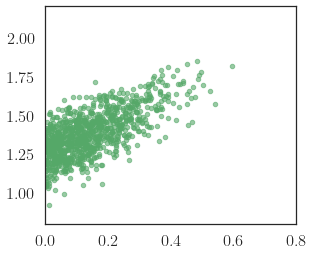

In [7]:
f, ax = plt.subplots(1, 1, figsize=(4.5, 4))
theta_hmc_np = theta_hmc.numpy()[:, :2]
ax.scatter(theta_hmc_np[:, 0], theta_hmc_np[:, 1], alpha=.6, c="g", s=20)
ax.set_xlim([0, 0.8])
ax.set_ylim([0.8, 2.2])

In [9]:
# np.set_printoptions(precision=3, suppress=True)
# print(theta_hmc.numpy()[:50])

In [10]:
def run(target, ground_truth_set, method="smvd", lr=0.005, n_chain=10):
    # g = tf.random.Generator.from_seed(1)
    eta0 = target.mirror_map.nabla_psi(theta_init[None, :]) + tf.random.normal([n_chain, K, D], dtype=tf.float64)
    # eta: [n_chain, K, D - 1]
    eta = tf.Variable(eta0)
    theta0 = target.mirror_map.nabla_psi_star(eta0)
    if method == "proj_svgd":
        theta = tf.Variable(theta0)
    else:
        theta = theta0
        # eta: [n_chain, K, D - 1]
        eta = tf.Variable(eta0)
    n_iters = 1000
    kernel = imq
    eds = []
    trange = tqdm(range(n_iters))
    optimizer = tf.keras.optimizers.RMSprop(lr)

    for t in trange:
        if method == "svmd":
            eta_grad = svmd_update_v2(target, theta, kernel, n_eigen_threshold=0.99)
        elif method == "svgd":
            eta_grad = svgd_update(target, eta, theta, kernel)
        elif method == "proj_svgd":
            theta_grad = proj_svgd_update(target, theta, kernel)
        else:
            raise NotImplementedError()

        if method == "proj_svgd":
            optimizer.apply_gradients([(-theta_grad, theta)])
            theta.assign(tf.maximum(theta, 0.))
        else:
            optimizer.apply_gradients([(-eta_grad, eta)])
            theta = target.mirror_map.nabla_psi_star(eta)
        if t % 20 == 0:
            ed = energy_dist(ground_truth_set, theta[0])
            eds.append(ed.numpy())
    return tf.reshape(theta, [-1, theta.shape[-1]]), eds

In [11]:
methods = ["proj_svgd", "svmd", "svgd"]

In [12]:
ground_truth_set = theta_hmc

search_lr = [0.1, 0.01, 0.001]
samples_dict = defaultdict(list)
eds_dict = defaultdict(list)

for method in methods:
    # if method == "proj_svgd":
    #     search_lr = [0.01, 0.001, 1e-4]
    for lr in search_lr:
        theta, eds = run(target, ground_truth_set, method=method, lr=lr)
        eds_dict[method].append(eds)
        samples_dict[method].append(theta)

100%|██████████| 1000/1000 [00:04<00:00, 209.42it/s]


In [13]:
name_map = {
    "svgd": "MSVGD",
    "svmd": "SVMD",
    "proj_svgd": "SVGD w/ proj."
}

In [14]:
# np.set_printoptions(precision=3, suppress=True)
# print(samples_svgd[0].numpy()[:50])

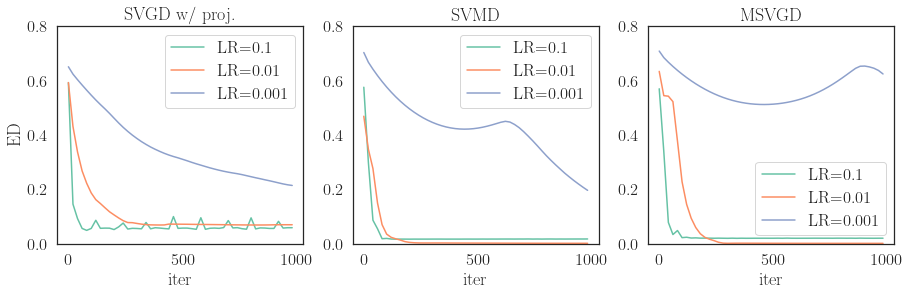

In [15]:
f, axes = plt.subplots(1, len(methods), figsize=(5 * len(methods), 4))

for i, method in enumerate(methods):
    # if method == "proj_svgd":
    #     search_lr_ = [0.01, 0.001, 1e-4]
    # else:
    search_lr_ = [0.1, 0.01, 0.001]
    for j, lr in enumerate(search_lr_):
        axes[i].plot(np.arange(len(eds_dict[method][0])) * 20, eds_dict[method][j], label="LR={}".format(lr))
    axes[i].set_title(name_map[method])
    axes[i].set_ylim(top=0.8, bottom=0)
    axes[i].set_xlabel("iter")
    if i == 0:
        axes[i].set_ylabel("ED")
    axes[i].legend()
# plt.savefig("quad_{}d_wrt_lr.pdf".format(D), bbox_inches="tight", dpi=150)

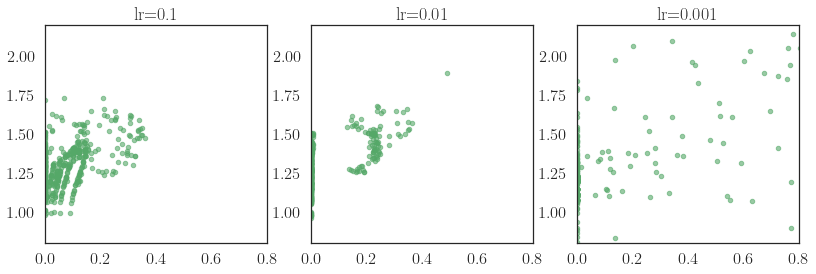

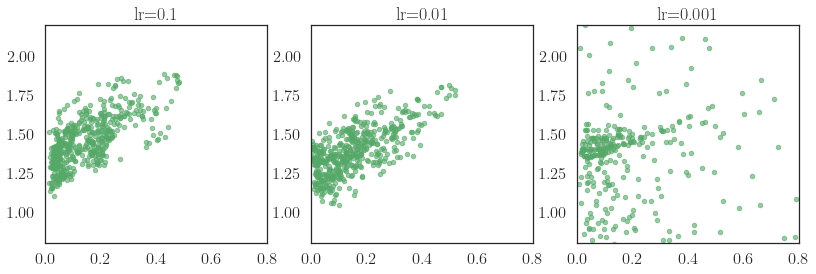

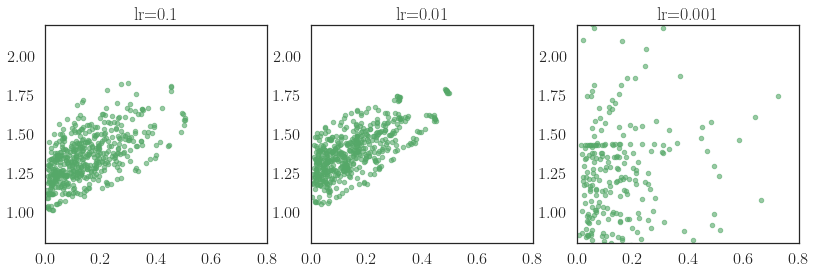

In [16]:
for method in methods:
    f, axes = plt.subplots(1, len(search_lr), figsize=(4.5 * len(search_lr), 4))
    for i, samples in enumerate(samples_dict[method]):
        if D == 3:
    #         f, ax = plt.subplots(1, 1, figsize=(4.5, 4))
            plot_simplex.plot_points(axes[i], samples.numpy(), alpha=.6, c="g", s=20)
        else:
    #         f, ax = plt.subplots(1, 1, figsize=(4.5, 4))
            samples_np = samples.numpy()
            axes[i].scatter(samples_np[:, 0], samples_np[:, 1], alpha=.6, c="g", s=20)
            axes[i].set_xlim([0, 0.8])
            axes[i].set_ylim([0.8, 2.2])
            axes[i].set_title("lr={}".format(search_lr[i]))

In [17]:
# import matplotlib.pyplot as plt
# from scipy import stats
# space = [np.linspace(0, 0.8, 100), np.linspace(0.8, 2.2, 100)]
# xx, yy = np.meshgrid(*space)
# print(xx.shape)
# print(yy.shape)
# coords = np.vstack(list(map(np.ravel, (xx, yy))))
# # coords.shape

In [18]:
# # f, axes = plt.subplots(1, len(methods), figsize=(5 * len(methods), 4))
# fig = plt.figure(figsize=(5 * len(methods), 4))
# for i, method in enumerate(methods):
#     ax = fig.add_subplot(1, len(methods), i + 1, projection='3d')
#     samples = samples_dict[method][1].numpy()
#     print(samples.shape)
#     kde = stats.gaussian_kde(samples.T)
#     kde.set_bandwidth(bw_method=kde.factor / 2.)
#     density = kde(coords).reshape(xx.shape)
#     print(density.shape)
#     surf = ax.plot_surface(xx, yy, density, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
#     ax.set_title(method)

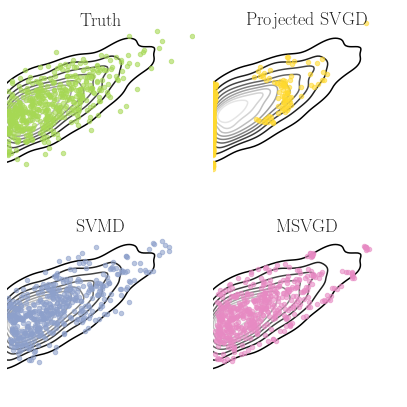

In [20]:
name_map = {
    "svgd": "MSVGD",
    "svmd": "SVMD",
    "truth": "Truth",
    "proj_svgd": "Projected SVGD",
}

f, axes = plt.subplots(2, 2, figsize=(3 * 2, 3 * 2), sharex=True, sharey=True)
axes = np.ravel(axes)
palette = sns.color_palette("Set2", 6)[-4:]
for i, method in enumerate(["truth"] + methods):
    # cmap = sns.cubehelix_palette(start=0, light=1, as_cmap=True)
    # cmap = sns.light_palette(color='#8da0cb',n_colors=7,reverse=False,input='RGB', as_cmap=True)
    sns.kdeplot(x=theta_hmc_np[:, 0], y=theta_hmc_np[:, 1], cmap="Greys_r", levels=10, cut=10, fill=False, ax=axes[i], zorder=1)
    if i == 0:
        samples = theta_hmc_np[:500, :]
    else:
        samples = samples_dict[method][1].numpy()
    # sns.scatterplot(x=samples[:, 0], y=samples[:, 1], s=6, color="0.1", ax=axes[i])
    axes[i].scatter(samples[:, 0], samples[:, 1], alpha=0.6, s=20, color=palette[(2 + i) % 4], zorder=2)
    axes[i].set_xlim([0, 0.6])
    axes[i].set_ylim([0.8, 2])
    axes[i].set_axis_off()
    # axes[i].set_title(name_map[method], position=(0.5, 0.9))
    axes[i].text(.5, .9, name_map[method], horizontalalignment='center', transform=axes[i].transAxes)
plt.tight_layout()
plt.savefig("sel2d.pdf", bbox_inches="tight", dpi=150)